In [34]:
# Imports
from matplotlib.collections import LineCollection
from matplotlib import cm
import math

import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
#import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass

from tqdm import tqdm

import sys
module_path = 'maze_utils' 
if module_path not in sys.path:
    sys.path.append(module_path)

from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
# Define and populate the maze structure ma, used as an argument for many functions
ma=NewMaze(6)

# non-valid maze parts
re=[[-0.5,0.5,1,1],[-0.5,4.5,1,1],[-0.5,8.5,1,1],[-0.5,12.5,1,1],
       [2.5,13.5,1,1],[6.5,13.5,1,1],[10.5,13.5,1,1],
       [13.5,12.5,1,1],[13.5,8.5,1,1],[13.5,4.5,1,1],[13.5,0.5,1,1],
       [10.5,-0.5,1,1],[6.5,-0.5,1,1],[2.5,-0.5,1,1],
       [6.5,1.5,1,1],[6.5,11.5,1,1],[10.5,5.5,1,1],[10.5,7.5,1,1],
       [5.5,4.5,1,1],[5.5,8.5,1,1],[7.5,4.5,1,1],[7.5,8.5,1,1],[2.5,5.5,1,1],[2.5,7.5,1,1],
       [-0.5,2.5,3,1],[-0.5,10.5,3,1],[11.5,10.5,3,1],[11.5,2.5,3,1],[5.5,0.5,3,1],[5.5,12.5,3,1],
       [7.5,6.5,7,1]]

In [419]:
# get a path of a bout (list of coordinates)
def get_path_552(nickname,b):
    tf=LoadTraj(nickname+'-tf')
    x=-0.5+15*tf.ke[b][:,0]
    y=-0.5+15*tf.ke[b][:,1]
    t=np.linspace(0,1,x.shape[0]) # time variable
    points_raw = np.array([list(x),list(y)]).transpose().tolist()
    points_no_nan = list(filter(lambda x: (not math.isnan(x[0])) or (not math.isnan(x[1])), points_raw))
    points_rounded = np.array(np.round(points_no_nan), dtype=int)
    points_valid = [x for x in points_rounded if tuple(x) in ma.ce.keys()]
    points_valid = remove_consecutive_duplicate_coords(points_valid)
    #points = [i for (i,j) in zip(points_valid[1:], points_valid) if len(ConnectPath(ma.ce[tuple(j)], ma.ce[tuple(i)], ma))<6]

    new_points = [np.array([0, 7])]
    for next_coord, curr_coord in zip(points_valid[1:], points_valid):
        path_length = len(ConnectPath(ma.ce[tuple(curr_coord)], ma.ce[tuple(next_coord)], ma))
        if path_length<4:
            new_points.append(next_coord)

    points_copy = new_points.copy()
    offset = 0
    for i, (x,y) in enumerate(zip(new_points[1:], new_points)):
        path = ConnectPath(ma.ce[tuple(y)], ma.ce[tuple(x)], ma)
        if len(path)>2:
            coords = []
            for idx in path[1:-1]:
                coords.append(np.array([ma.xc[idx], ma.yc[idx]]))
            points_copy[i+1+offset:i+1+offset] = coords
            offset += len(coords)

    return points_copy, t

In [42]:
# plot a path (list of coordinates) with path coloured based on time
def plot_path_552_time(points, t, ax):
    points = np.array(points).reshape(-1,1,2)

    segs=np.concatenate([points[:-1],points[1:]],axis=1) # array of segments
    lc=LineCollection(segs,cmap=plt.get_cmap('viridis'),linewidths=1.5) # collect segments
    lc.set_array(t) # color the segments by the time variable
    plot(ma.wa[:,0],ma.wa[:,1],fmts=['k-'],equal=True,linewidth=1,yflip=True,
              xhide=True,yhide=True,axes=ax) # Draw the maze outline    
    for r in re:
        rect=patches.Rectangle((r[0],r[1]),r[2],r[3],linewidth=1,edgecolor='lightgray',facecolor='lightgray')
        ax.add_patch(rect)
    ax.axis('off'); # turn off the axes
    ax.add_collection(lc); # add the collection to the plot

In [60]:
# plot a path (list of coordinates) without time
def plot_path_552(points, ax):
    points = np.array(points).reshape(-1,1,2)

    segs=np.concatenate([points[:-1],points[1:]],axis=1) # array of segments
    lc=LineCollection(segs,cmap=plt.get_cmap('viridis'),linewidths=1.5) # collect segments
    lc.set_array(np.linspace(0,1,points.shape[0])) # color the segments
    plot(ma.wa[:,0],ma.wa[:,1],fmts=['k-'],equal=True,linewidth=1,yflip=True,
              xhide=True,yhide=True,axes=ax) # Draw the maze outline    
    for r in re:
        rect=patches.Rectangle((r[0],r[1]),r[2],r[3],linewidth=1,edgecolor='lightgray',facecolor='lightgray')
        ax.add_patch(rect)
    ax.add_collection(lc); # add the collection to the plot
    ax.axis('off'); # turn off the axes

In [40]:
# removes consective duplicate coords from a path list of coordinates
def remove_consecutive_duplicate_coords(path):
    return [v for i, v in enumerate(path) if i == 0 or (path[i] != path[i-1]).any()]

In [54]:
# get first proper bouts (beyond the first junction) of all 19 animals
with open('outdata/HomeRuns', 'rb') as f:
    Names,HR=pickle.load(f) # bout, starting node, node distance, absolute frame   
sb=[hr[hr[:,2]>1,0][0] for hr in HR] # bout of first home run if past first intersection
paths, time = [], []
sb_dict = {}
for i,nickname in tqdm(enumerate(Names), total=len(Names)):
    sb_dict[nickname] = sb[i]
    path, time_var = get_path_552(nickname,sb[i])
    paths.append(path)
    time.append(time_var)

100%|██████████| 19/19 [00:27<00:00,  1.45s/it]


100%|██████████| 19/19 [00:13<00:00,  1.45it/s]


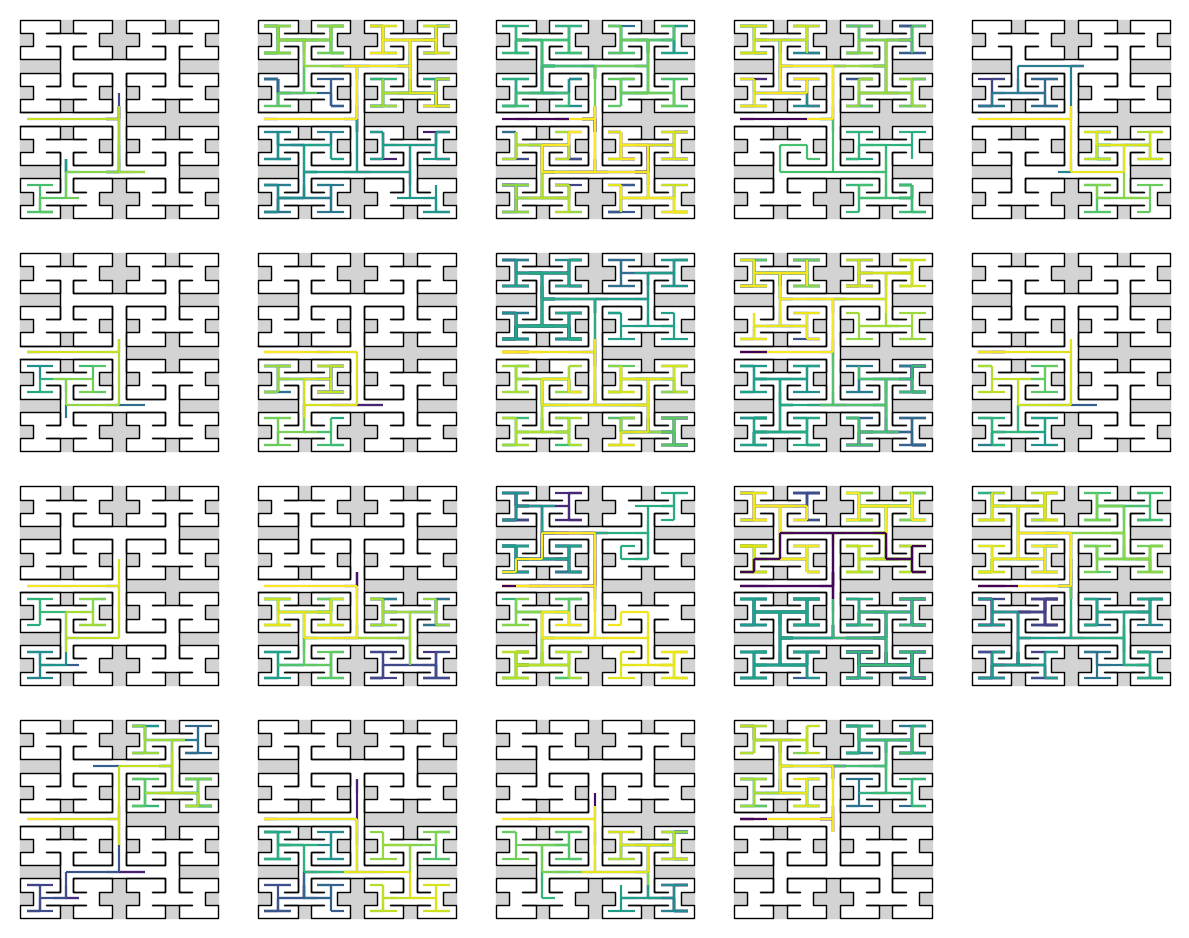

In [45]:
# plot first proper bouts (beyond the first junction) of all 19 animals (with time)
fig,ax=plt.subplots(4,5,figsize=(12,10))
for i, path in tqdm(enumerate(paths), total=len(paths)):
    plot_path_552_time(path, time[i], ax[i//5,i%5])

lastax=ax[-1,-1] # deal with the last panel
plot([0],[0],fmts=['w.'],equal=True,yflip=True,
          xhide=True,yhide=True,axes=lastax) # Draw nothing, helps for some reason 
lastax.axis('off')
plt.show()

100%|██████████| 19/19 [00:21<00:00,  1.12s/it]


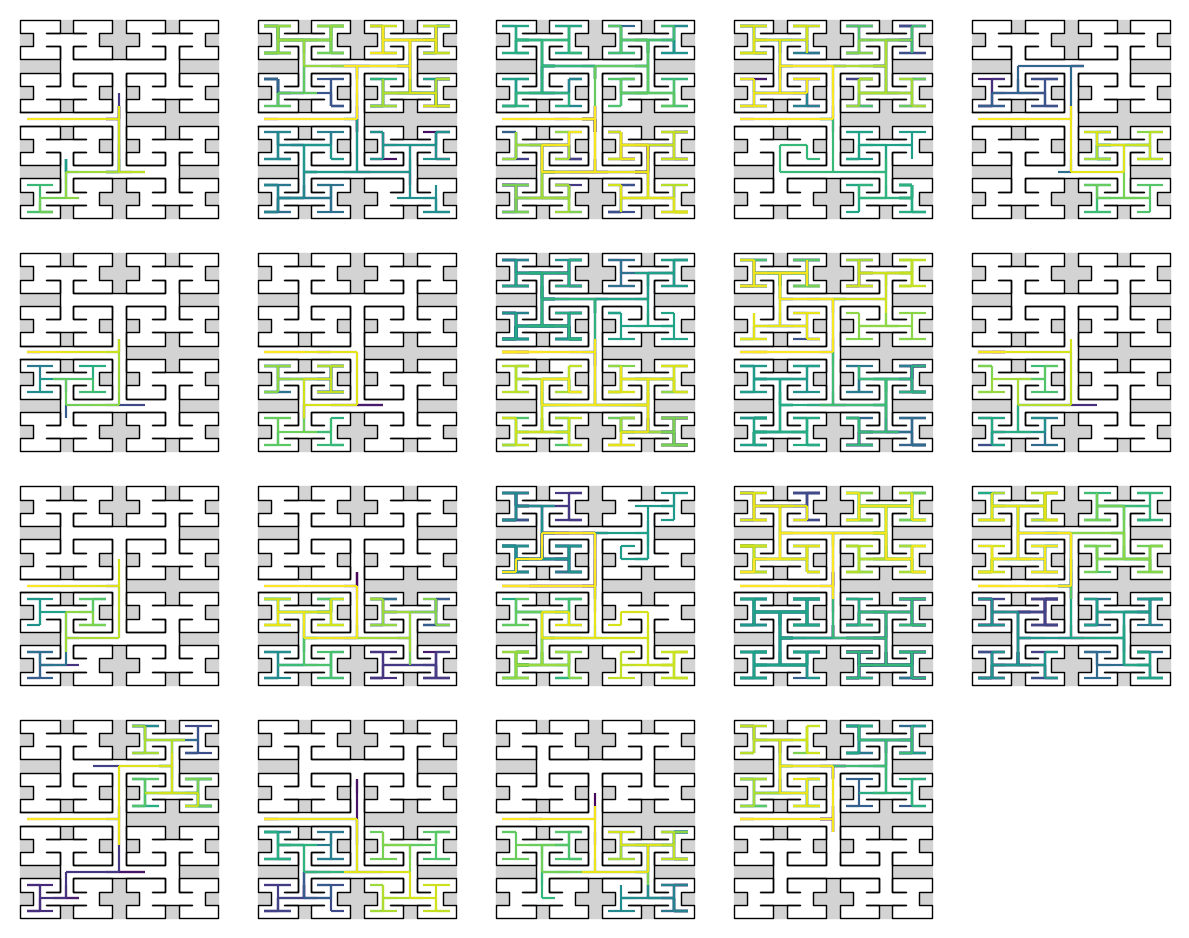

In [61]:
# plot first proper bouts (beyond the first junction) of all 19 animals (no time)
fig,ax=plt.subplots(4,5,figsize=(12,10))
for i, path in tqdm(enumerate(paths), total=len(paths)):
    path_no_time = remove_consecutive_duplicate_coords(path)
    plot_path_552(path_no_time, ax[i//5,i%5])

lastax=ax[-1,-1] # deal with the last panel
plot([0],[0],fmts=['w.'],equal=True,yflip=True,
          xhide=True,yhide=True,axes=lastax) # Draw nothing, helps for some reason 
lastax.axis('off')
plt.show()

In [183]:
end_nodes = []
for node_idx_list in ma.ru:
    end_nodes.append(node_idx_list[-1])

# this is a mess, but it works. Please don't judge :(
def steps_to_mouse_action(step_list, index_list):
    actions = []
    for i, (next_step, curr_step) in enumerate(zip(step_list[1:], step_list)):
        if (next_step == 'node_in' and curr_step == 'node_in') or (next_step == 'node_out' and curr_step == 'node_out'):
            actions.append('straight')
        elif (next_step == 'node_in' and curr_step == 'node_out'):
            if index_list[i+1] in end_nodes:
                if index_list[i+1]>=112:
                    actions.append('dead end turn around')
                else:
                    actions.append('node turn around')
            else:
                actions.append('turn around')
        elif (next_step == 'node_out' and curr_step == 'node_in'):
            if index_list[i+1] in end_nodes:
                if index_list[i+1]>=112:
                    actions.append('dead end turn around')
                else:
                    actions.append('node turn around')
            else:
                actions.append('turn around')
        elif (next_step == 'in left' and curr_step == 'node_in'):
            actions.append('left turn')
        elif (next_step == 'in right' and curr_step == 'node_in'):
            actions.append('right turn')
        elif (next_step == 'in left' and curr_step == 'out left'):
            if index_list[i+1] in end_nodes:
                if index_list[i+1]>=112:
                    actions.append('dead end turn around')
                else:
                    actions.append('node turn around')
            else:
                actions.append('turn around')
        elif (next_step == 'in right' and curr_step == 'out right'):
            if index_list[i+1] in end_nodes:
                if index_list[i+1]>=112:
                    actions.append('dead end turn around')
                else:
                    actions.append('node turn around')
            else:
                actions.append('turn around')
        elif (next_step == 'out left' and curr_step == 'in left'):
            if index_list[i+1] in end_nodes:
                if index_list[i+1]>=112:
                    actions.append('dead end turn around')
                else:
                    actions.append('node turn around')
            else:
                actions.append('turn around')
        elif (next_step == 'out right' and curr_step == 'in right'):
            if index_list[i+1] in end_nodes:
                if index_list[i+1]>=112:
                    actions.append('dead end turn around')
                else:
                    actions.append('node turn around')
            else:
                actions.append('turn around')
        elif (next_step == 'in left' and curr_step == 'out right'):
            actions.append('straight through node')
        elif (next_step == 'in right' and curr_step == 'out left'):
            actions.append('straight through node')
        elif (next_step == 'node_in' and curr_step == 'in left'):
            actions.append('straight')
        elif (next_step == 'node_in' and curr_step == 'in right'):
            actions.append('straight')
        elif (next_step == 'out left' and curr_step == 'node_out'):
            actions.append('straight')
        elif (next_step == 'out right' and curr_step == 'node_out'):
            actions.append('straight')
        elif (next_step == 'node_out' and curr_step == 'out left'):
            actions.append('right turn')
        elif (next_step == 'node_out' and curr_step == 'out right'):
            actions.append('left turn')
        elif (next_step == 'in right' and curr_step == 'in left'):
            actions.append('right turn')
        elif (next_step == 'in left' and curr_step == 'in left'):
            actions.append('left turn')
        elif (next_step == 'in right' and curr_step == 'in right'):
            actions.append('right turn')
        elif (next_step == 'in left' and curr_step == 'in right'):
            actions.append('left turn')
        elif (next_step == 'out left' and curr_step == 'out left'):
            actions.append('right turn')
        elif (next_step == 'out right' and curr_step == 'out right'):
            actions.append('left turn')
        elif (next_step == 'out left' and curr_step == 'out right'):
            actions.append('right turn')
        elif (next_step == 'out right' and curr_step == 'out left'):
            actions.append('left turn')
        else:
            actions.append('NOT HANDLED')

    return actions

In [188]:
#these are just all the ones in outdata
mouse_names= ['B1','B2','B3', 'B4', 'B5', 'B6', 'B7', 'C1', 'C3', 'C6','C7', 'C8','C9','D3','D4','D5','D6','D7','D8','D9']

#dictionaries for all mice
action_dict={}

# loop through bouts
for mouse, sb in tqdm(sb_dict.items()):
    path, time_var = get_path_552(mouse, sb)
    path_no_time = remove_consecutive_duplicate_coords(path)
    
    #convert coordinates to indices
    index_list = [ma.ce[tuple(coord)] for coord in path_no_time] 

    # convert indicies to nodes
    # maze.ru is a list of lists, where the inner lists are the indices of the coordinates that are associated to each node
    node_list= []
    for index in index_list:
        for i, node_idx_list in enumerate(ma.ru):
            if index in node_idx_list:
                node_list.append(i)

    # convert nodes to steps
    step_list= []
    for i, (start, end) in enumerate(zip(node_list, node_list[1:])):
        if start == end:
            # travelling inwards along node
            if index_list[i+1] > index_list[i]:
                step_type = 'node_in'
            # travelling outwards along node
            elif index_list[i+1] < index_list[i]:
                step_type = 'node_out'
        else:
            # changing nodes
            step_type = ma.st[start,end]
            
        step_list.append(step_type)

    for i, step_num in enumerate(step_list):
        # in left = 0; in right = 1; out left = 2; out right = 3; illegal = -1
        if step_num == 0:
            step_list[i] = 'in left'
        elif step_num == 1:
            step_list[i] = 'in right'
        elif step_num == 2:
            step_list[i] = 'out left'
        elif step_num == 3:
            step_list[i] = 'out right'

    # convert steps to actions (left/right/back/straight/illegal)
    action_dict[mouse] = steps_to_mouse_action(step_list, index_list)

100%|██████████| 19/19 [00:49<00:00,  2.60s/it]


<AxesSubplot:>

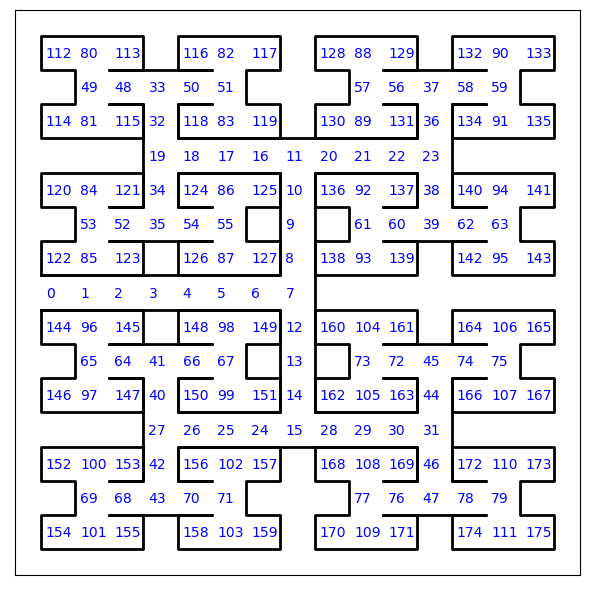

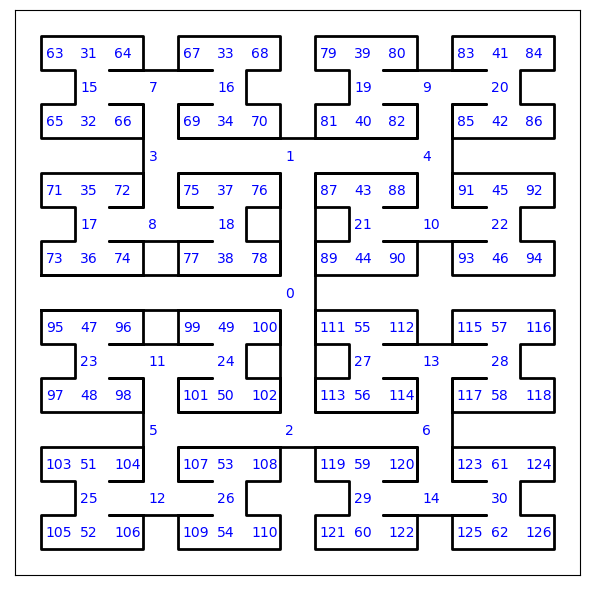

In [88]:
PlotMazeCells(ma)
PlotMazeNodes(ma)


In [179]:
# actions_copy = actions.copy()
# steps_copy = step_list.copy()
# indices_copy = index_list.copy()
# steps_copy.insert(0,0)
# actions_copy.insert(0,0)
# actions_copy.insert(0,0)

In [180]:
# import pandas as pd
# pd.DataFrame({'index': indices_copy, 'step': steps_copy, 'action': actions_copy}).to_csv('results.csv')

In [209]:
# get % of actions/movements (probably want per mouse and also overall)
from collections import Counter
metrics_dict = {}
for mouse, actions in action_dict.items():
    # count percent of each action
    counts_dict = dict(Counter(actions))
    counts_dict = dict(sorted(counts_dict.items()))

    pc_dict = {}
    for k, v in counts_dict.items():
        pc_dict[k] = round(v/len(actions)*100,2)

    metrics_dict[mouse] = pc_dict

    # count how many consecutive same turns there are
    turns = []
    for action in actions:
        if action in ['left turn', 'right turn']:
            turns.append(action)

    consecutive_same_turns = []
    count = 0
    for next_turn, curr_turn in zip(turns[1:], turns):
        if next_turn == curr_turn:
            count += 1
        else:
            consecutive_same_turns.append(count)
            count = 0
    #print(dict(sorted(dict(Counter(consecutive_same_turns)).items())))

    same_or_not = []
    for next_turn, curr_turn in zip(turns[1:], turns):
        if next_turn == curr_turn:
            same_or_not.append('same')
        else:
            same_or_not.append('different')
    print(dict(sorted(dict(Counter(same_or_not)).items())))
    


{'different': 13, 'same': 12}
{'different': 244, 'same': 335}
{'different': 266, 'same': 417}
{'different': 169, 'same': 270}
{'different': 61, 'same': 74}
{'different': 11, 'same': 10}
{'different': 41, 'same': 68}
{'different': 306, 'same': 501}
{'different': 253, 'same': 356}
{'different': 26, 'same': 35}
{'different': 22, 'same': 27}
{'different': 112, 'same': 135}
{'different': 235, 'same': 360}
{'different': 516, 'same': 821}
{'different': 307, 'same': 418}
{'different': 58, 'same': 79}
{'different': 61, 'same': 70}
{'different': 65, 'same': 92}
{'different': 151, 'same': 162}


In [202]:
dead_ends = 0
lefts = 0
rights = 0
node_reverses = 0
reverses = 0
straights = 0
node_straights = 0
for k, v in metrics_dict.items():
    dead_ends += v['dead end turn around']
    lefts += v['left turn']
    rights += v['right turn']
    straights += v['straight']
    node_straights += v['straight through node']
    reverses += v['turn around']
    node_reverses += v['node turn around']

overall_metrics = {'dead end turn around': round(dead_ends/len(metrics_dict),2),
                   'left turn': round(lefts/len(metrics_dict),2),
                   'right turn': round(rights/len(metrics_dict),2),
                   'straight': round(straights/len(metrics_dict),2),
                   'straight through node': round(node_straights/len(metrics_dict),2),
                   'turn around': round(reverses/len(metrics_dict),2),
                   'node turn around': round(node_reverses/len(metrics_dict),2)}

In [203]:
overall_metrics

{'dead end turn around': 15.01,
 'left turn': 16.63,
 'right turn': 16.74,
 'straight': 21.26,
 'straight through node': 13.51,
 'turn around': 8.77,
 'node turn around': 8.1}

# Next steps:
1. only get rewarded mice (10 of them)
2. get paths of all rewarded mice past first intersection (done below, but not yet separated by reward vs. non-reward)
3. cut the paths off if they reach index 165, otherwise let the paths go until they exit
4. get metric for how many nodes they visit before reaching the reward
5. get metric for how many times they visit a node


In [234]:
with open('outdata/HomeRuns', 'rb') as f:
    Names,HR=pickle.load(f) # bout, starting node, node distance, absolute frame   
sb=[hr[hr[:,2]>1,0] for hr in HR] # bout of first home run if past first intersection
bout_dict = {}
for mouse, sb_list in zip(Names, sb):
    bout_dict[mouse] = sb_list

In [399]:
#for bout in range(len)
RewNames=['B1','B2','B3','B4','C1','C3','C6','C7','C8','C9']
for name in RewNames:
    tf=LoadTraj(f'{name}-tf')
    for bout in range(len(tf.ke)):
        path, _ = get_path_552(name, bout)
        path = [ma.ce[tuple(coord)] for coord in path]
    